In [1]:
import csv

class Task:
    def __init__(self, name, ancestors, duration):
        self.name = name
        self.ancestors = {} if (ancestors == {'-'}) else ancestors
        self.duration = duration
        self.rank = -1
        self.children = set()
        
    def __repr__(self):
        s = f"Task('{self.name}', {self.ancestors}, {self.duration}"
        if self.rank != -1:
            s += f", {self.rank}"
        if self.children: #if not empty
            s += f", {self.children}"
        s += ")"
        return s

def read_tasks_file(file):
    task_dict = {}
    with open(file, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            task_dict[row['Tâches']] = Task(row['Tâches'], set(row['Ancêtres'].split(", ")), int(row['Durée']))
    return task_dict

task_dict = read_tasks_file("construction.csv")
print(task_dict)

{'A': Task('A', {}, 5), 'B': Task('B', {'A'}, 4), 'C': Task('C', {'B'}, 2), 'D': Task('D', {'C'}, 2), 'E': Task('E', {'F', 'D'}, 3), 'F': Task('F', {'C'}, 5), 'G': Task('G', {'B'}, 3), 'H': Task('H', {'G'}, 3), 'I': Task('I', {'H', 'F'}, 4), 'J': Task('J', {'E', 'I'}, 10), 'K': Task('K', {'M', 'J'}, 5), 'L': Task('L', {}, 15), 'M': Task('M', {'L'}, 3)}


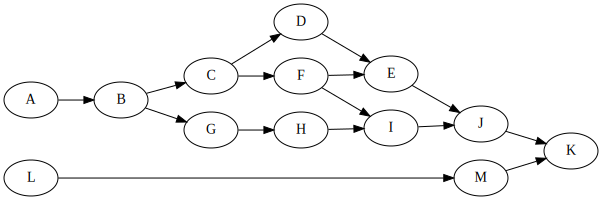

In [2]:
import graphviz

def generate_basic_graph(task_dict):
    dot = graphviz.Digraph()
    dot.graph_attr['rankdir'] = 'LR'  

    for task in task_dict.values():
        if task.ancestors == {}:
            with dot.subgraph() as s:
                s.attr(rank='min')
                s.node(task.name)
        else:
            for ancestor in task.ancestors:
                dot.edge(ancestor, task.name)
    return dot

dot = generate_basic_graph(task_dict)
# print(dot.source)
dot

ordered_nodes=('A', 'L', 'B', 'M', 'C', 'G', 'D', 'F', 'H', 'E', 'I', 'J', 'K')
rank_dict=defaultdict(<class 'list'>, {0: ['A', 'L'], 1: ['B', 'M'], 2: ['C', 'G'], 3: ['D', 'F', 'H'], 4: ['E', 'I'], 5: ['J'], 6: ['K']})


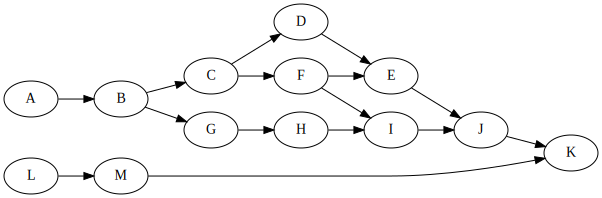

In [3]:
from graphlib import TopologicalSorter
from collections import defaultdict

def topological_sort(task_dict):
    # Topological sort of the graph
    task_graph = {k : v.ancestors for k, v in task_dict.items()}
    ts = TopologicalSorter(task_graph)
    ordered_nodes = tuple(ts.static_order())
    return ordered_nodes

ordered_nodes = topological_sort(task_dict)
print(f'{ordered_nodes=}')

def calculate_ranks_and_children(ordered_nodes, task_dict):
    # Calculate ranks to display nodes with the same rank in the same 'column'
    # Initiate task.children for each node so we can process the graph in reverse order 
    for k in ordered_nodes:
        task = task_dict[k]
        
        max_rank = -1
        for a in task.ancestors:
            ancestor = task_dict[a]
            if ancestor.rank > max_rank:
                max_rank = ancestor.rank  
            ancestor.children.add(k)
        task.rank = max_rank + 1
        
calculate_ranks_and_children(ordered_nodes, task_dict)
# print(f'{task_dict=}')

def create_rank_list(task_dict):
    # Create a dictionnary contraining a list of tasks with the rank as keys: {0: ['A', 'L'], 1: ['B', 'M'], ...}
    task_rank_list = [(k, v.rank) for k, v in task_dict.items()]   
    # we use a list to conserve order of insertion
    rank_dict = defaultdict(list)
    for k, v in task_rank_list:
        rank_dict[v].append(k)
    return rank_dict

rank_dict = create_rank_list(task_dict)
print(f'{rank_dict=}')

def generate_ranked_graph(task_dict, rank_dict):
    # Creating the graph where tasks with the same rank are in the same column
    dot_2 = graphviz.Digraph()
    dot_2.graph_attr['rankdir'] = 'LR'

    for rank, tasks in rank_dict.items():
        with dot_2.subgraph() as s:
                s.attr(rank='same')
                for t in tasks:
                    s.node(t)
        for t in tasks:
            task = task_dict[t]
            if task.ancestors != {}:
                for ancestor in task.ancestors:
                    dot_2.edge(ancestor, task.name)
    return dot_2

dot_2 = generate_ranked_graph(task_dict, rank_dict)
dot_2

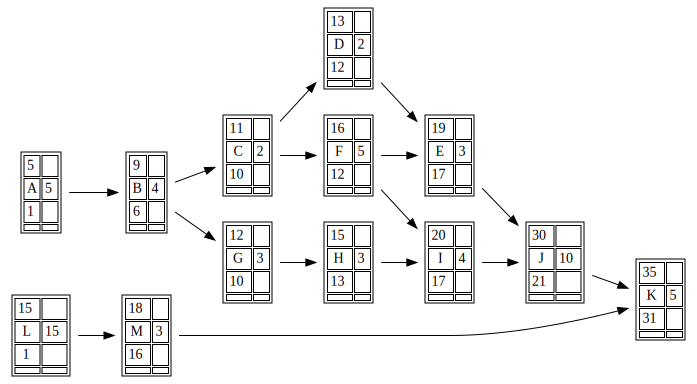

In [4]:
def calculate_au_plus_tot(ordered_nodes, task_dict):
    # Calcul "debut_au_plus_tot" et "fin_au_plus_tot"
    for k in ordered_nodes:
        task = task_dict[k]
        # "debut_au_plus_tot"
        if task.ancestors == {}:
            task.debut_au_plus_tot = 1 
        else:
            task.debut_au_plus_tot = max([task_dict[ancestor].fin_au_plus_tot for ancestor in task.ancestors]) + 1
        # "fin_au_plus_tot"
        task.fin_au_plus_tot = task.debut_au_plus_tot + task.duration - 1

calculate_au_plus_tot(ordered_nodes, task_dict)

def generate_au_plus_tot_graph(task_dict, rank_dict):
    # Creating the graph with "debut_au_plus_tot" and "fin_au_plus_tot"
    dot_3 = graphviz.Digraph()
    dot_3.graph_attr['rankdir'] = 'LR'

    for rank, tasks in rank_dict.items():
        with dot_3.subgraph() as s:
                s.attr(rank='same')
                for t in tasks:
                    task = task_dict[t]
                    s.node(t, shape='plaintext', label=f'''<<TABLE>
                           <TR><TD>{task.fin_au_plus_tot}</TD><TD></TD></TR>
                           <TR><TD>{task.name}</TD><TD>{task.duration}</TD></TR>
                           <TR><TD>{task.debut_au_plus_tot}</TD><TD></TD></TR>
                           <TR><TD></TD><TD></TD></TR>
                           </TABLE>>''')
        for t in tasks:
            task = task_dict[t]
            if task.ancestors != {}:
                for ancestor in task.ancestors:
                    dot_3.edge(ancestor, task.name)
    return dot_3

dot_3 = generate_au_plus_tot_graph(task_dict, rank_dict)
dot_3

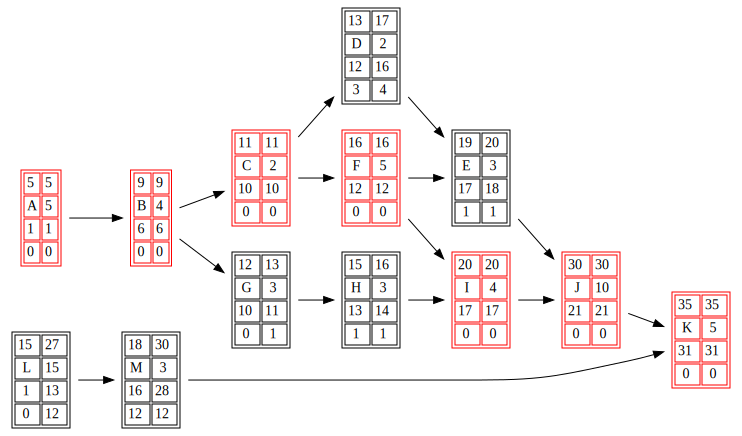

In [5]:
def calculate_everything_else(ordered_nodes, task_dict):
    # Calcul "debut_au_plus_tard", "fin_au_plus_tard", "marge_totale" et "marge_libre"
    for k in reversed(ordered_nodes):
        task = task_dict[k]
        # "fin_au_plus_tard"
        if not task.children: # if empty
            task.fin_au_plus_tard = task.fin_au_plus_tot 
            task.marge_libre = 0
        else:
            task.fin_au_plus_tard = min([task_dict[child].debut_au_plus_tard for child in task.children]) - 1
            task.marge_libre = min([task_dict[child].debut_au_plus_tot for child in task.children]) - task.fin_au_plus_tot - 1 
        # "debut_au_plus_tard"
        task.debut_au_plus_tard = task.fin_au_plus_tard - task.duration + 1
        task.marge_totale = task.debut_au_plus_tard - task.debut_au_plus_tot
        
calculate_everything_else(ordered_nodes, task_dict)

def generate_final_graph(task_dict, rank_dict):
    # Creating the graph with "debut_au_plus_tard" and "fin_au_plus_tard"
    dot_4 = graphviz.Digraph("graph")
    dot_4.graph_attr['rankdir'] = 'LR'
    # dot_4.node_attr['margin'] = '0'

    for rank, tasks in rank_dict.items():
        with dot_4.subgraph() as s:
                s.attr(rank='same')
                for t in tasks:
                    task = task_dict[t]
                    s.node(t, shape='plaintext', color= ('red' if task.marge_totale == 0 else 'black'),
                           label=f'''<<TABLE>
                           <TR><TD>{task.fin_au_plus_tot}</TD><TD>{task.fin_au_plus_tard}</TD></TR>
                           <TR><TD>{task.name}</TD><TD>{task.duration}</TD></TR>
                           <TR><TD>{task.debut_au_plus_tot}</TD><TD>{task.debut_au_plus_tard}</TD></TR>
                           <TR><TD>{task.marge_libre}</TD><TD>{task.marge_totale}</TD></TR>
                           </TABLE>>''')
        for t in tasks:
            task = task_dict[t]
            if task.ancestors != {}:
                for ancestor in task.ancestors:
                    dot_4.edge(ancestor, task.name)
    return dot_4

dot_4 = generate_final_graph(task_dict, rank_dict)
dot_4

In [16]:
task_dict_2 = read_tasks_file("test_tasks.csv")
# print(task_dict_2)

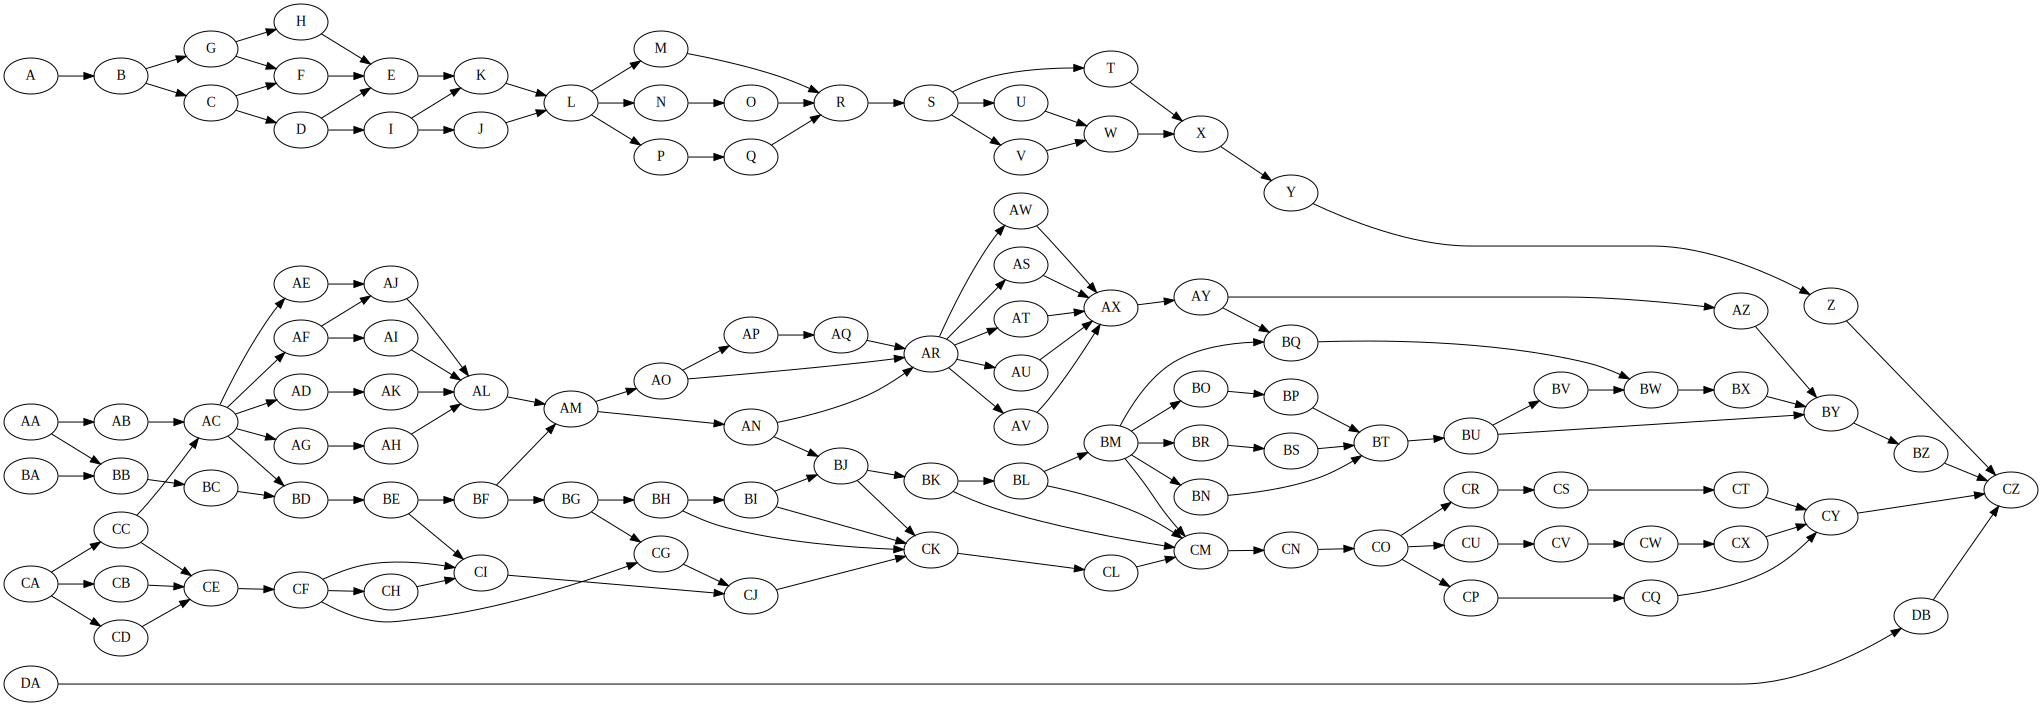

In [17]:
graph = generate_basic_graph(task_dict_2)
# print(graph.source)
graph

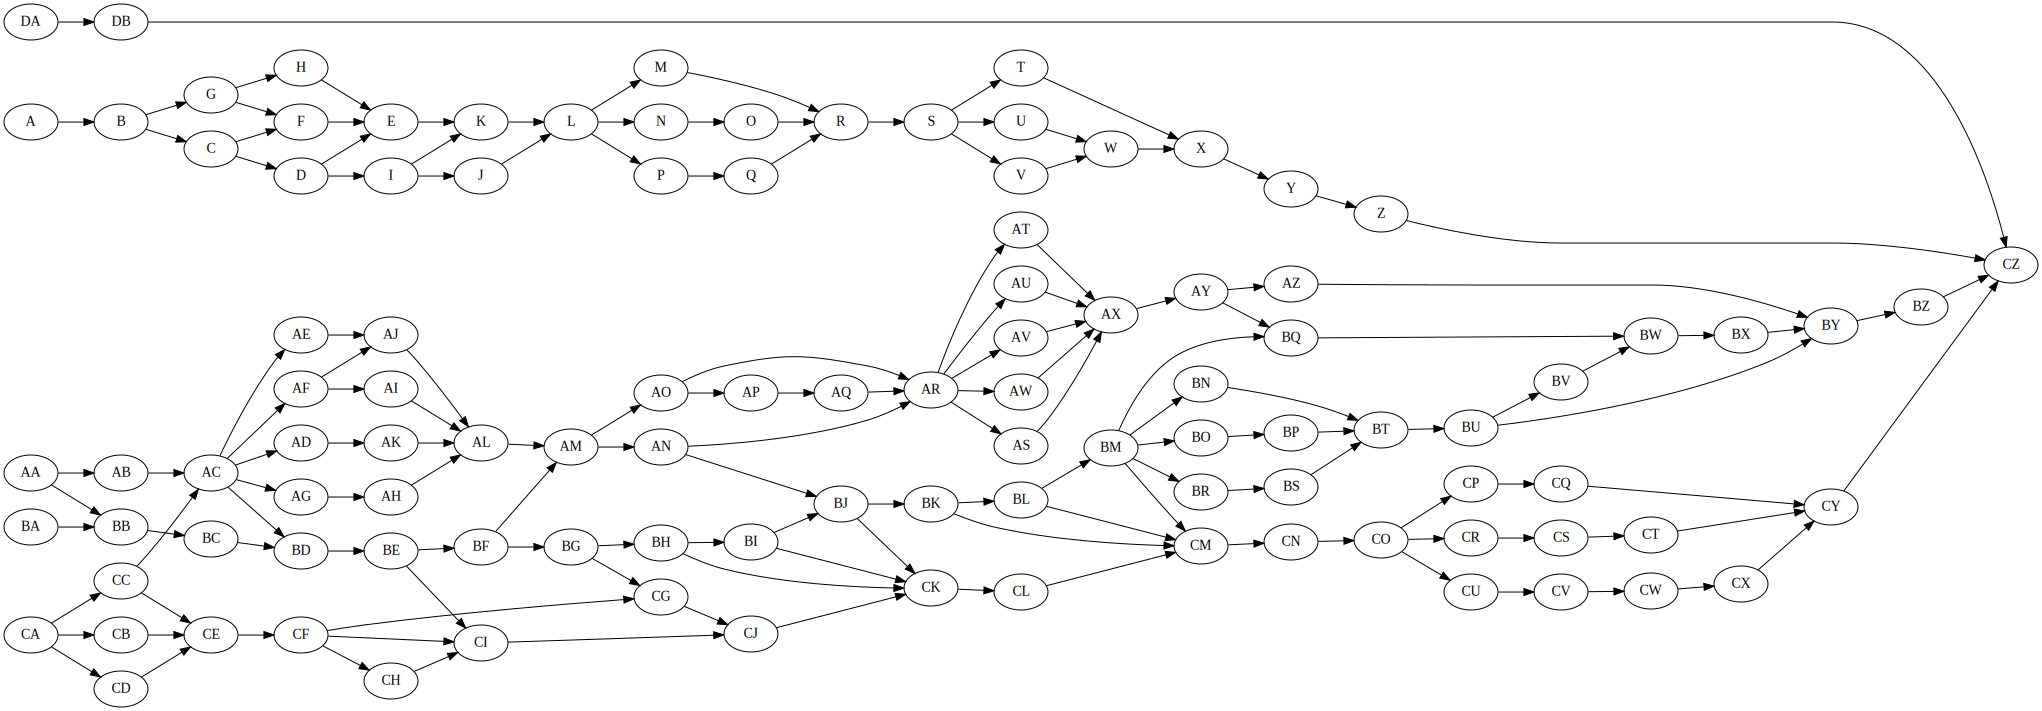

In [18]:
ordered_nodes_2 = topological_sort(task_dict_2)
# print(f'{ordered_nodes_2=}')
        
calculate_ranks_and_children(ordered_nodes_2, task_dict_2)
# print(f'{task_dict_2=}')

rank_dict_2 = create_rank_list(task_dict_2)
# print(f'{rank_dict_2=}')

graph_2 = generate_ranked_graph(task_dict_2, rank_dict_2)
graph_2

In [19]:
calculate_au_plus_tot(ordered_nodes_2, task_dict_2)

# graph_3 = generate_au_plus_tot_graph(task_dict_2, rank_dict_2)
# graph_3

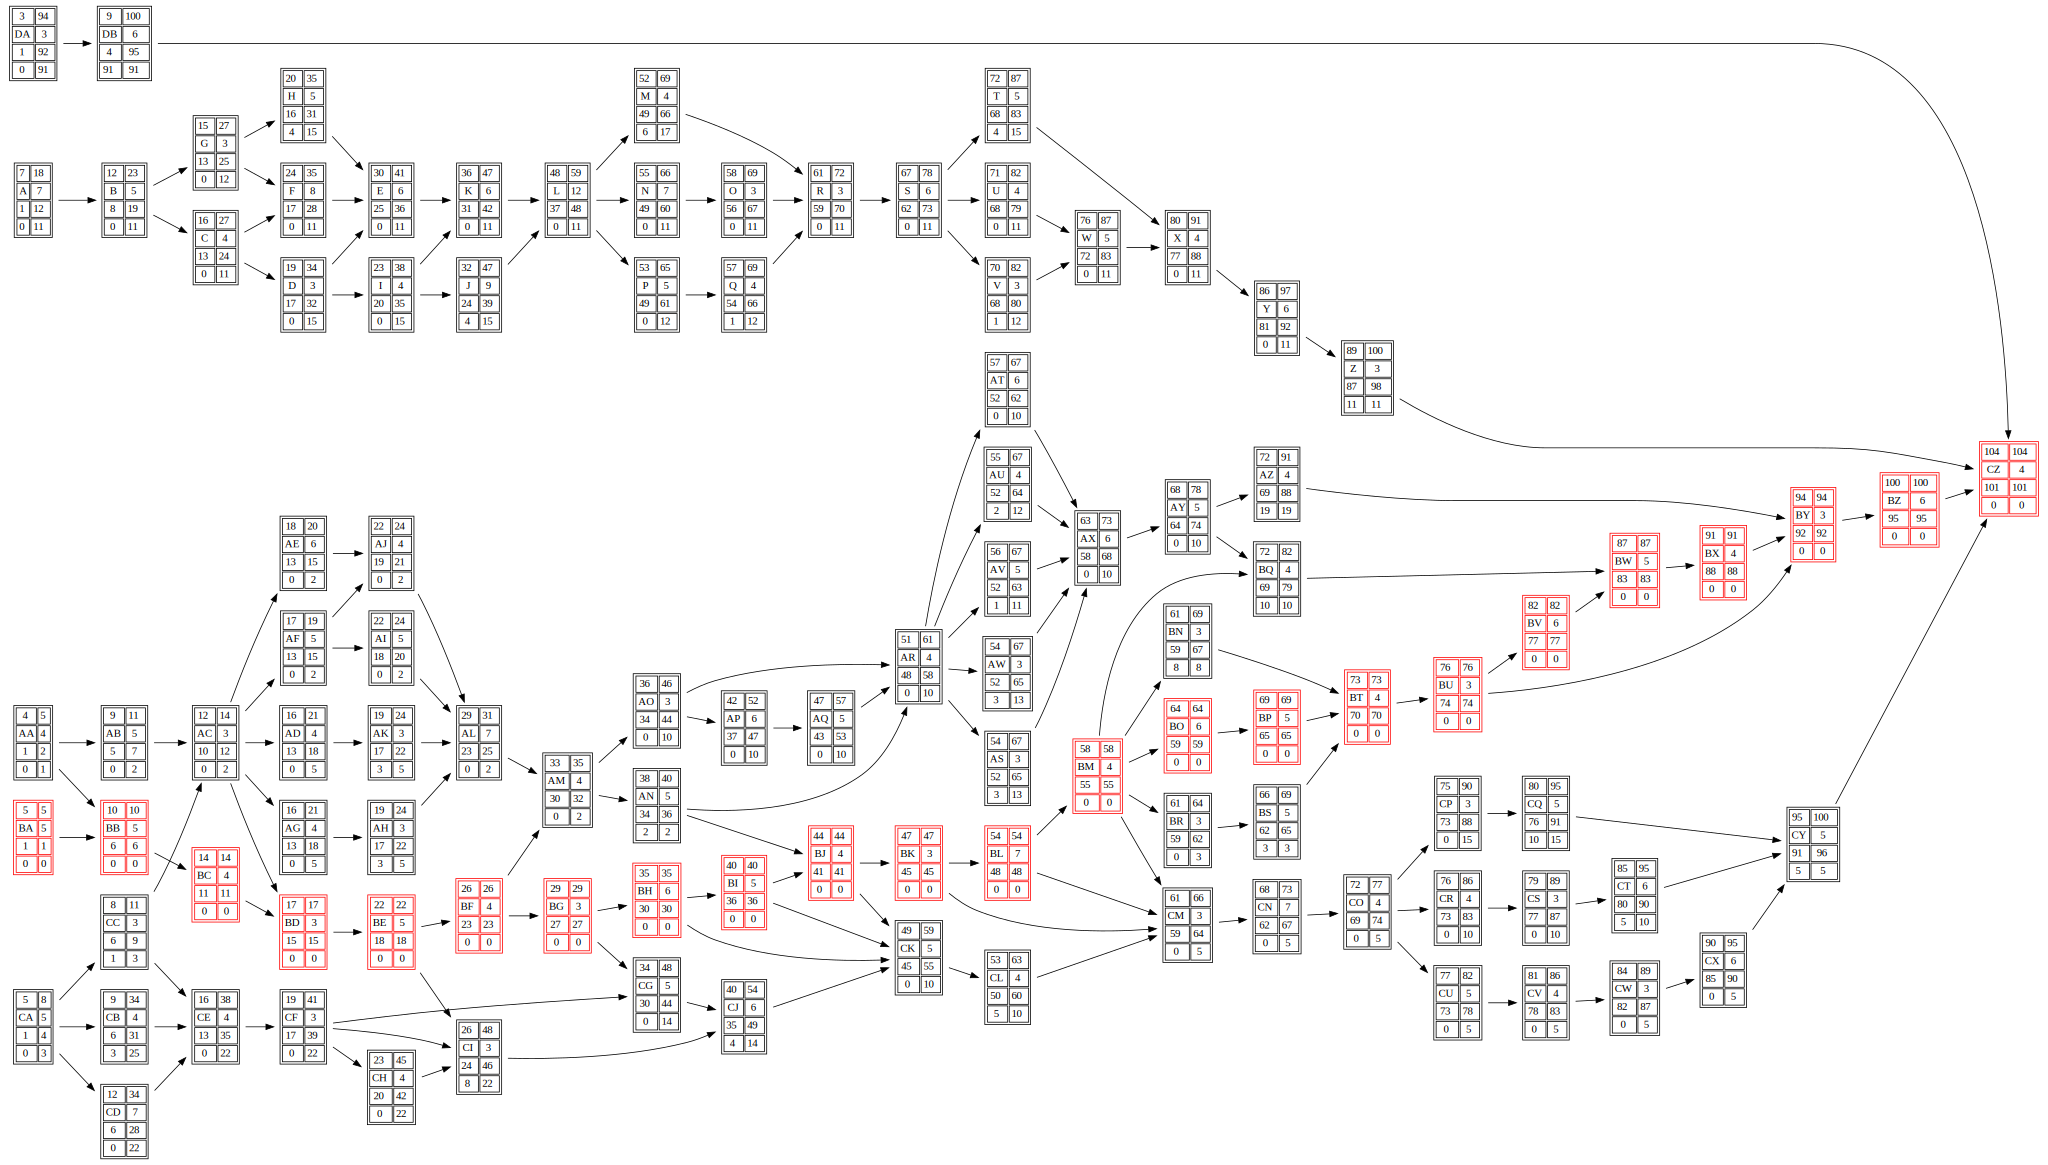

In [22]:
calculate_everything_else(ordered_nodes_2, task_dict_2)

graph_4 = generate_final_graph(task_dict_2, rank_dict_2)
graph_4

In [21]:
graph_4.format = 'png'
graph_4.render(directory='.')

'graph.gv.png'